In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pandas as pd
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

In [0]:
path = '/content/drive/My Drive/Cognitive'
os.chdir(path)
drivers_df = pd.read_csv("driver_imgs_list.csv")

In [0]:
drivers_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [0]:
!ls 'imgs/train'

c0  c1	c2  c3	c4  c5	c6  c7	c8  c9


In [0]:
# imgs_path = "imgs/"
# data = ImageDataBunch.from_folder(imgs_path, train=imgs_path+"train", valid_pct=0.2, test=imgs_path+"test", ds_tfms=get_transforms(), size=224, bs=16).normalize(imagenet_stats)

In [0]:
data = ImageDataBunch.from_folder('imgs/train', train='.', test='../test', valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (17940 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
c1,c1,c1,c1,c1
Path: imgs/train;

Valid: LabelList (4484 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
c3,c6,c3,c1,c2
Path: imgs/train;

Test: LabelList (27631 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: imgs/train

In [0]:
data.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], 10, 17940, 4484)

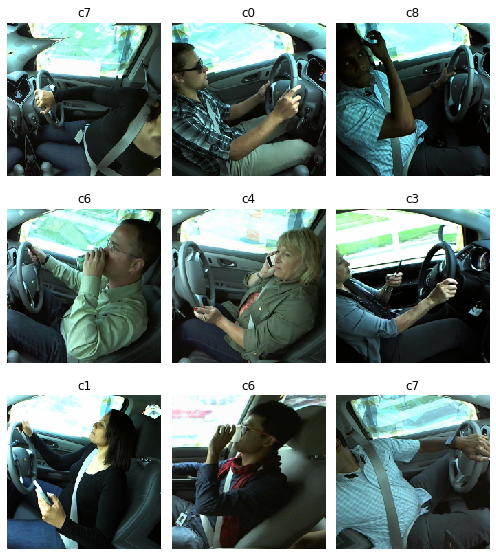

In [0]:
# data.show_batch(rows=3, figsize=(7,8))

In [0]:
len(drivers_df)

22424

In [0]:
from fastai.torch_core import *

import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from functools import partial

__all__ = ['XResNet', 'xresnet18', 'xresnet34', 'xresnet50', 'xresnet101', 'xresnet152']

In [0]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from functools import partial

In [0]:
act_fn = nn.ReLU(inplace=True)
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
  "Create and initialize a `nn.Conv1d` layer with spectral normalization."
  conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
  nn.init.kaiming_normal_(conv.weight)
  if bias: conv.bias.data.zero_()
  return spectral_norm(conv)

class SimpleSelfAttention(nn.Module):
  def __init__(self, n_in:int, ks=1, sym=False):#, n_out:int):
    super().__init__()      
    self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
    self.gamma = nn.Parameter(tensor([0.]))    
    self.sym = sym
    self.n_in = n_in

  def forward(self,x):      
    if self.sym:
      # symmetry hack by https://github.com/mgrankin
      c = self.conv.weight.view(self.n_in,self.n_in)
      c = (c + c.t())/2
      self.conv.weight = c.view(self.n_in,self.n_in,1)

    size = x.size()  
    x = x.view(*size[:2],-1)   # (C,N)
      
    # changed the order of mutiplication to avoid O(N^2) complexity
    # (x*xT)*(W*x) instead of (x*(xT*(W*x)))
    convx = self.conv(x)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
    xxT = torch.bmm(x,x.permute(0,2,1).contiguous())   # (C,N) * (N,C) = (C,C)   => O(NC^2)
    o = torch.bmm(xxT, convx)   # (C,C) * (C,N) = (C,N)   => O(NC^2)
    o = self.gamma * o + x
    return o.view(*size).contiguous()

In [0]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1,sa=False, sym=False):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        
        self.sa = SimpleSelfAttention(nf,ks=1,sym=sym) if sa else noop
        
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.sa(self.convs(x)) + self.idconv(self.pool(x)))
    

    

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))



    
class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000, sa = False, sym= False):
        
        
        stem = []
        sizes = [c_in,32,64,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2, sa = sa if i in[len(layers)-4] else False, sym=sym)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride, sa=False, sym=False):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, sa if i in [blocks -1] else False,sym)
              for i in range(blocks)])

def xresnet(expansion, n_layers, name, pretrained=False,  **kwargs):
    model = XResNet(expansion, n_layers, **kwargs)
    if pretrained: model.load_state_dict(model_zoo.load_url(model_urls[name]))
    return model

me = sys.modules[__name__]
for n,e,l in [
    [ 18 , 1, [2,2,2 ,2] ],
    [ 34 , 1, [3,4,6 ,3] ],
    [ 50 , 4, [3,4,6 ,3] ],
    [ 101, 4, [3,4,23,3] ],
    [ 152, 4, [3,8,36,3] ],
]:
    name = f'xresnet{n}'
    setattr(me, name, partial(xresnet, expansion=e, n_layers=l, name=name))

In [0]:
torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80
self_attention = 1
symmetry = 0
mom = 0.9 # parameter momentum
alpha = 0.99 # parameter alpha
eps = 1e-6 # parameter epsilon
opt = 'adam' # 'rms', 'sgd'
if opt=='adam': opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
elif opt=='rms': opt_func = partial(optim.RMSprop, alpha=alpha, eps=eps)
elif opt=='sgd': opt_func = partial(optim.SGD, momentum=mom)
log_cb = partial(CSVLogger,filename=log)

In [0]:
learn = (Learner(data, xresnet50(c_out=10, sa=self_attention, sym=symmetry), wd=1e-2, opt_func=opt_func,
             metrics=[accuracy,top_k_accuracy, error_rate],
             bn_wd=False, true_wd=True,
             loss_func = LabelSmoothingCrossEntropy()
             ))

In [0]:
lr = 1e-3 # learning rate
epochs = 5
learn = learn.to_fp16(dynamic=True)
learn.unfreeze()
learn.fit_one_cycle(epochs, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,error_rate,time
0,1.556028,2.281220,0.396744,0.832962,0.603256,1:00:06
1,0.872789,0.931766,0.840544,0.996432,0.159456,12:44
2,0.693013,0.640874,0.975022,0.999108,0.024978,12:43
3,0.610543,0.588714,0.985058,1.000000,0.014942,12:47
4,0.569503,0.551136,0.995094,0.999777,0.004906,12:54


In [0]:
learn.model_dir = os.getcwd()+'/imgs/models'
learn.save('Self-attention2')

In [0]:
learn.export('self-attention2.pkl')

In [0]:
#learn = learn.load('Self-attention1')

In [0]:
preds = learn.get_preds()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

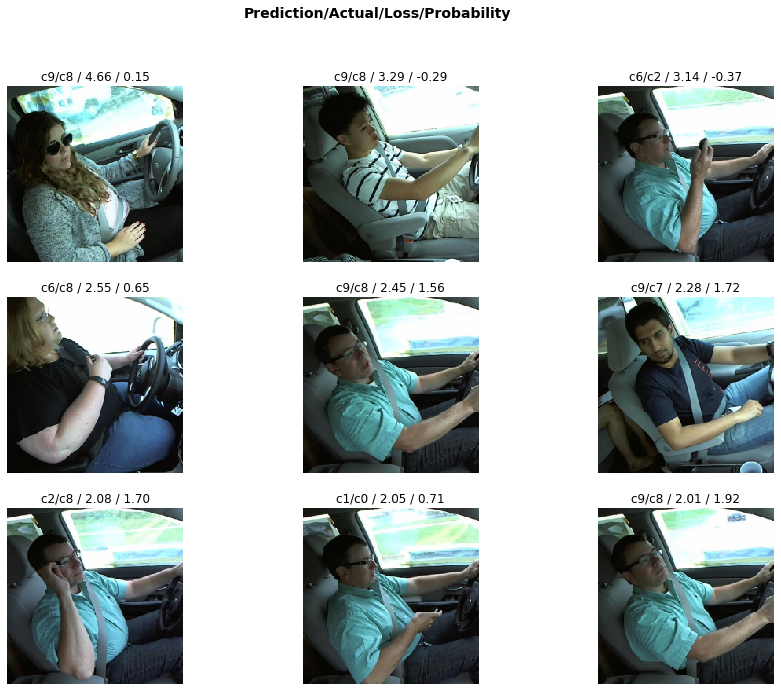

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

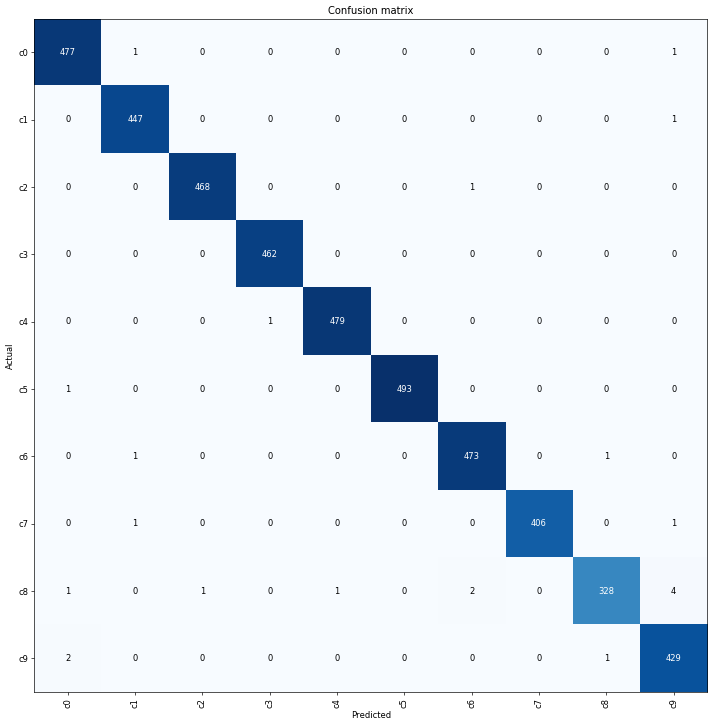

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)